In [1]:
from utils import utils

from pathlib import Path
from typing import List
from PIL.Image import Image
from PIL import Image as Im
from skimage import filters
from scipy.signal import convolve2d
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm


import os
import PIL 
import cv2
import torch
import copy

import numpy as np
import matplotlib.pyplot as plt




In [2]:
        
def check_overlap(ba, bb, threshold:float=0.5):
    
    y1, x1, h1, w1 = ba
    y2, x2, h2, w2 = bb
    
    
    # Calculate the coordinates of the bounding boxes
    x1_min, y1_min, x1_max, y1_max = x1, y1, x1 + w1, y1 + h1
    x2_min, y2_min, x2_max, y2_max = x2, y2, x2 + w2, y2 + h2
    

    # Calculate the intersection area
    intersection_area = max(0, min(x1_max, x2_max) - max(x1_min, x2_min)) * \
                        max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
    
    
        # Calculate areas of each bounding box
    area_bbox1 = (x1_max - x1_min) * (y1_max - y1_min)
    area_bbox2 = (x2_max - x2_min) * (y2_max - y2_min)
    
        # Calculate areas of each bounding box
    area_bbox1 = w1 * h1
    area_bbox2 = w2 * h2

    
    overlap_ratio = intersection_area / min(area_bbox1, area_bbox2)
    return overlap_ratio >= threshold

def non_maximun_supression(bboxes:list, threshold:float=0.5):
    final_voting = []
    bbox_list = copy.copy(bboxes)
    while len(bbox_list) > 0:
        current_box = bbox_list.pop(0)
        final_voting.append(current_box)
        for bbox in bbox_list:
            overlap = check_overlap(current_box[0], bbox[0])
            if overlap:
                bbox_list.remove(bbox)
                
    return final_voting


def convert2lab(img: np.ndarray):
    return (cv2.cvtColor(img, cv2.COLOR_BGR2LAB))

def convert2luv(img: np.ndarray):
    return (cv2.cvtColor(img, cv2.COLOR_BGR2LUV))


def convert2yuv(img: np.ndarray):
    return (cv2.cvtColor(img, cv2.COLOR_BGR2YUV))

def convert2hsv(img: np.ndarray):
    return (cv2.cvtColor(img, cv2.COLOR_BGR2HSV))


def convert2rg_chromaticity(img: np.ndarray) -> np.ndarray:
    """
    Convert a linear RGB image to rg chromaticity color space.

    Parameters:
        img (np.ndarray): The input linear RGB image as a NumPy array.

    Returns:
        np.ndarray: The image in rg chromaticity color space as a NumPy array.
    """
    r,g,b = cv2.split(img)
    r_c = r /(img.sum(axis=2)+1e-8)
    g_c = g /(img.sum(axis=2)+1e-8)
    b_c = np.ones_like(r_c) - r_c
    return np.dstack((r_c, g_c, b_c))


def conver2colorspace(img, colorspace=convert2lab):
    return colorspace(img)

    
def normalize(img, m=0., mx=1.):
    return cv2.normalize(img, None, m, mx, cv2.NORM_MINMAX, dtype=cv2.CV_32F)


def apply_morpholical_grad(image, kernel):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
    return op

def sharpening(img):
    kernel = np.array([[0, -1, 0],
                        [-1, 10, -1],
                        [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel)
    
    return sharpened


def apply_morpholical_grad(image, kernel):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
    return op


def apply_open(image, kernel, iters:int=3):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel, iters)
    return op

def apply_dilate(image, kernel, iterations:int=5):
    
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.dilate(image, kernel, iterations = iterations)
    return op

def apply_closing(image, kernel):
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closing


def apply_erode(image, kernel):
    
    if isinstance(kernel, tuple):
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,  
                                   kernel)
        
        
    op = cv2.erode(image, kernel)
    return op


def getGradientMagnitude(im):
    "Get magnitude of gradient for given image"
    ddepth = cv2.CV_32F
    dx = cv2.Sobel(im, ddepth, 1, 0)
    dy = cv2.Sobel(im, ddepth, 0, 1)
    dxabs = cv2.convertScaleAbs(dx)
    dyabs = cv2.convertScaleAbs(dy)
    mag = cv2.addWeighted(dxabs, 0.5, dyabs, 0.5, 0)
    return mag



def estimate_noise(I):

    H, W = I.shape

    M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]

    sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
    sigma = sigma * np.sqrt(0.5 * np.pi) / (6 * (W-2) * (H-2))

    return sigma


def remove_background(image):
    rgb_planes = cv2.split(image)
    result_norm_planes = []

    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)

    enhanced = cv2.merge(result_norm_planes)
    return enhanced


def CDenoissing(image):
    
    (r, g, b) = cv2.split(image)

    b_blur = cv2.medianBlur(b, 3)
    g_blur = cv2.medianBlur(g, 3)
    r_blur = cv2.medianBlur(r, 3)

    b_denoise = cv2.fastNlMeansDenoising(b_blur, 5, 9, 21)
    g_denoise = cv2.fastNlMeansDenoising(g_blur, 5, 9, 21)
    r_denoise = cv2.fastNlMeansDenoising(r_blur, 5, 9, 21)

    enhanced = cv2.merge((r_denoise, g_denoise, b_denoise))
    
    
    return enhanced

In [3]:
def extract_paintings(img:np.ndarray):
    paintings = {"result":[], "mask":None, "bbox": []}
    
    ## Preprocess of the image
    chromacity = conver2colorspace(img, colorspace=convert2rg_chromaticity)
    chromacity= (chromacity *255).astype(np.uint8)
    
    x = cv2.Sobel(chromacity, cv2.CV_64F, 1,0, ksize=3, scale=1)
    y = cv2.Sobel(chromacity, cv2.CV_64F, 0,1, ksize=3, scale=1)
    absx= cv2.convertScaleAbs(x)
    absy = cv2.convertScaleAbs(y)
    edge = cv2.addWeighted(absx, 1.5, absy, 1.5, 10)
    
    kernel = (int(edge.shape[0]*0.01), int(edge.shape[1]*0.01))
    edges = cv2.Canny(edge, 75, 100)
    
    binary = apply_closing(edges, kernel)
    #binary = apply_open(binary, (3,3))
    binary[0:5,:] = 0
    binary[:,0:5] = 0
    binary[-5:, :] = 0
    binary[:, -5:] = 0
    
    # Flood filling the background to remove external noise
    tmp_mask = binary.copy()
    heigh_im, width_im = tmp_mask.shape
    mask = np.zeros((heigh_im+2, width_im+2), np.uint8)
    
    cv2.floodFill(tmp_mask, mask, (1,1), 255)
    inv = cv2.bitwise_not(tmp_mask)
    
    ## invert to remove background
    mask = inv +binary
    
    
    ## finding the contourns
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    decission = []
    
    area_total = heigh_im * width_im

    for contour in contours:
        convexHull = cv2.convexHull(contour)

        perimeter = cv2.arcLength(convexHull, True)
        x,y,w,h = cv2.boundingRect(convexHull)
        aspect_ratio = w/h
        area = w*h
        proportion_height =  h/heigh_im
        proportion_width = w / width_im

        if (proportion_height > 0.15) and (proportion_width > 0.15):
            decission.append(([y,x,h,w], perimeter, area ,aspect_ratio))



    decission = sorted(decission, key=lambda x: x[2], reverse=True)
    decission = non_maximun_supression(decission)
    
    if len(decission) >2:
        decission = decission[:2]
        
    decission = sorted(decission, key=lambda x: x[0][1])
    
    final_mask = np.zeros(img.shape[:2])  
    for bbox in decission:
        y,x,h,w = bbox[0]
        cropped = img[y:y+h, x:x+w, :]
        final_mask[y:y+h, x:x+w] = 1
        paintings["result"].append(cropped)
        paintings["bbox"].append(bbox[0])
    
    paintings["mask"] = final_mask
    
    return paintings


def refine_mask(img: np.ndarray):

    
    # Preprocessing the image
    img = conver2colorspace(img, colorspace=convert2rg_chromaticity)
    img = ((normalize(img[:,:,0]))*255).astype(np.uint8)
    
    new_mask = np.zeros_like(img)
    
    
    ### Applying the derivates
    x = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=3, scale=1)
    y = cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=3, scale=1)
    absx= cv2.convertScaleAbs(x)
    absy = cv2.convertScaleAbs(y)
    edge = cv2.addWeighted(absx, 5, absy, 5, 0)

    thr = filters.threshold_otsu(edge)
    edge = (edge > thr).astype(np.uint8)
    

    
    ## Apply hough transform
    mask = np.zeros_like(edge)
    
    h_, w_ = edge.shape
    
    mask = np.zeros_like(edge)
    max_line_gap = int(edge.shape[1] * 0.05)
    h_, w_ = edge.shape
    votes_min_l = int(min(h_*0.35, w_*0.35))

    linesP = cv2.HoughLinesP(edge, 1, np.pi / 180, votes_min_l, minLineLength=votes_min_l, maxLineGap=max_line_gap)   

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(mask, (l[0], l[1]), (l[2], l[3]), 255, 3, cv2.LINE_AA)
            

    ## Apply region growing flood fill
    img2 = mask.copy()
    h, w = img2.shape
    mask_ = np.zeros((h+2, w+2), np.uint8)
    seed = (w//2,h//2)
    
    # Filling the center of the painting
    cv2.floodFill(img2, mask_, seed, 255)
    inv = cv2.bitwise_not(img2)
    
    mask_ = mask + img2
    

    ## Get the center of the image
    contours, hierarchy = cv2.findContours(mask_, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    decission = []
    heigh_im, width_im = edge.shape

    area_total = heigh_im * width_im


    for contour in contours:
        convexHull = cv2.convexHull(contour)

        perimeter = cv2.arcLength(convexHull, True)
        x,y,w,h = cv2.boundingRect(convexHull)
        aspect_ratio = w/h
        area = w*h
        proportion_height =  h/heigh_im
        proportion_width = w / width_im

        if (proportion_height  > 0.15) and (proportion_width > 0.15) and width_im :
            decission.append(([y,x,h,w], perimeter, area ,aspect_ratio))


    decission = sorted(decission, key=lambda x: x[2], reverse=True)
    decission = non_maximun_supression(decission)
    
    #print(decission)
    
    new_bbox = decission[0][0]
    y,x,h,w = new_bbox
    new_mask[y:y+h, x:x+w] = 1
    
    
    return new_bbox, new_mask



def run_painting_extraction(BBDD):
    
    dic_paintings = {}
    
    for idx, im in tqdm(enumerate(BBDD)):
        image = cv2.imread(str(im))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray_image = (cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
        if estimate_noise(gray_image) > 1:
            image = CDenoissing(image)
        
        ### First painting extraction
        paintings = extract_paintings(image)
        final_mask = np.zeros_like(paintings["mask"])

        for i, paint_extracted in enumerate(paintings["result"]):

            new_bbox = []
            old_bbox = paintings["bbox"][i]
            new_bbox, new_mask_img = refine_mask(paint_extracted)
            
            yn, xn, hn, wn = new_bbox

            # Realocate the new refined masks
            new_y =  (old_bbox[0] + new_bbox[0])
            new_x =  (old_bbox[1] + new_bbox[1])

            h = new_bbox[-2]
            w = new_bbox[-1]

            final_mask[new_y:new_y+h, new_x:new_x+w] = 1
            paintings["result"][i] = paintings["result"][i][yn:yn+hn, xn:xn+wn]
            new_bbox.append([new_y, new_x, h, w])
        

        paintings["bbox"] = new_bbox
        paintings["mask"] = final_mask
        paintings["name"] = im.name
        
        
        dic_paintings[idx] = paintings

    return dic_paintings




## Mirar filtre de gabor per la setmana vinent per fer el refinament i la detecció dels quadres

# TODO MIRAR PER QUE NO FUNCIONA AMB LO NOU 

In [7]:

BBDD =  sorted(utils.read_bbdd(Path("../data/qst2_w3")))
print(BBDD)

[WindowsPath('../data/qst2_w3/00000.jpg'), WindowsPath('../data/qst2_w3/00001.jpg'), WindowsPath('../data/qst2_w3/00002.jpg'), WindowsPath('../data/qst2_w3/00003.jpg'), WindowsPath('../data/qst2_w3/00004.jpg'), WindowsPath('../data/qst2_w3/00005.jpg'), WindowsPath('../data/qst2_w3/00006.jpg'), WindowsPath('../data/qst2_w3/00007.jpg'), WindowsPath('../data/qst2_w3/00008.jpg'), WindowsPath('../data/qst2_w3/00009.jpg'), WindowsPath('../data/qst2_w3/00010.jpg'), WindowsPath('../data/qst2_w3/00011.jpg'), WindowsPath('../data/qst2_w3/00012.jpg'), WindowsPath('../data/qst2_w3/00013.jpg'), WindowsPath('../data/qst2_w3/00014.jpg'), WindowsPath('../data/qst2_w3/00015.jpg'), WindowsPath('../data/qst2_w3/00016.jpg'), WindowsPath('../data/qst2_w3/00017.jpg'), WindowsPath('../data/qst2_w3/00018.jpg'), WindowsPath('../data/qst2_w3/00019.jpg'), WindowsPath('../data/qst2_w3/00020.jpg'), WindowsPath('../data/qst2_w3/00021.jpg'), WindowsPath('../data/qst2_w3/00022.jpg'), WindowsPath('../data/qst2_w3/0002

In [8]:
p = run_painting_extraction(BBDD) ## Aquest és el pipeline

30it [02:47,  5.58s/it]


In [34]:
import pickle

with open('resultado_pickel_wk3.pkl', 'rb') as f:
    predictions = pickle.load(f)
print(predictions)

[[116, 218, 239, 140, 176, 154, 142, 248, 57, 51], [36, 11, 254, 109, 222, 53, 238, 32, 207, 251], [184, 170, 223, 130, 262, 36, 281, 11, 245, 24], [104, 232, 51, 70, 116, 167, 258, 132, 259, 168], [211, 87, 19, 193, 235, 95, 227, 257, 143, 42], [147, 225, 215, 63, 135, 51, 132, 248, 192, 142], [94, 212, 43, 58, 237, 116, 147, 259, 232, 174], [41, 9, 7, 182, 31, 3, 192, 145, 84, 35], [28, 237, 116, 123, 258, 94, 51, 245, 69, 174], [109, 283, 245, 47, 277, 206, 36, 251, 11, 222], [43, 150, 35, 147, 160, 176, 239, 142, 57, 65], [147, 160, 65, 135, 103, 142, 239, 286, 167, 84], [260, 239, 147, 279, 113, 57, 248, 40, 103, 60], [170, 184, 245, 36, 11, 24, 223, 130, 277, 281], [215, 192, 239, 113, 160, 248, 142, 60, 271, 57], [183, 209, 270, 208, 27, 58, 189, 9, 233, 226], [76, 205, 191, 16, 37, 142, 187, 156, 99, 244], [27, 209, 168, 102, 69, 23, 103, 248, 286, 34], [245, 44, 109, 184, 36, 138, 24, 11, 171, 170], [192, 233, 190, 160, 69, 225, 237, 113, 130, 215], [36, 11, 238, 92, 164, 254,

In [35]:
from PIL import Image
from skimage import measure


paints = []
query_folder = Path('../data/qst2_w3')
preictions_fixed = []
paint_count = 0
for file in query_folder.glob('masks/*.png'):
    predictions_inside = []
    #results = []
    #image = np.array(Image.open(query_folder / (Path(file).stem + '.jpg')))
    mask = np.array(Image.open(file))
    labels = measure.label(mask)
    for reg in measure.regionprops(labels):
        if reg.label == 0: 
            continue
        predictions_inside.append(predictions[paint_count])
        paint_count += 1
    preictions_fixed.append(predictions_inside)
        #results.append(image[reg.bbox[0]:reg.bbox[2], reg.bbox[1]:reg.bbox[3]])
    #paints.append({'result': results})

In [39]:
with open('result.pkl', 'wb') as f:
    pickle.dump(preictions_fixed, f)

In [40]:
with open('result.pkl', 'rb') as f:
    predictions = pickle.load(f)
print(predictions)

[[[116, 218, 239, 140, 176, 154, 142, 248, 57, 51]], [[36, 11, 254, 109, 222, 53, 238, 32, 207, 251]], [[184, 170, 223, 130, 262, 36, 281, 11, 245, 24], [104, 232, 51, 70, 116, 167, 258, 132, 259, 168]], [[211, 87, 19, 193, 235, 95, 227, 257, 143, 42]], [[147, 225, 215, 63, 135, 51, 132, 248, 192, 142], [94, 212, 43, 58, 237, 116, 147, 259, 232, 174]], [[41, 9, 7, 182, 31, 3, 192, 145, 84, 35], [28, 237, 116, 123, 258, 94, 51, 245, 69, 174]], [[109, 283, 245, 47, 277, 206, 36, 251, 11, 222]], [[43, 150, 35, 147, 160, 176, 239, 142, 57, 65]], [[147, 160, 65, 135, 103, 142, 239, 286, 167, 84]], [[260, 239, 147, 279, 113, 57, 248, 40, 103, 60]], [[170, 184, 245, 36, 11, 24, 223, 130, 277, 281]], [[215, 192, 239, 113, 160, 248, 142, 60, 271, 57]], [[183, 209, 270, 208, 27, 58, 189, 9, 233, 226]], [[76, 205, 191, 16, 37, 142, 187, 156, 99, 244]], [[27, 209, 168, 102, 69, 23, 103, 248, 286, 34], [245, 44, 109, 184, 36, 138, 24, 11, 171, 170]], [[192, 233, 190, 160, 69, 225, 237, 113, 130, 21

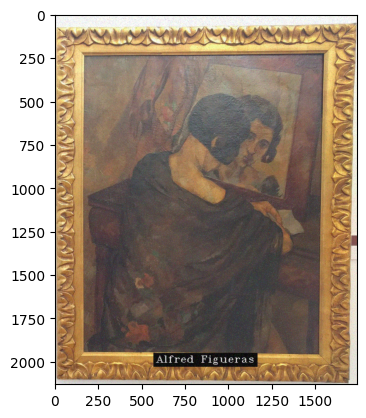

In [29]:
mypaint = paints[2]['result'][0]
plt.imshow(mypaint)
plt.show()

In [9]:
utils.write_pickle(information=p, filepath="./painting_extraction_qst2_w3.pkl")

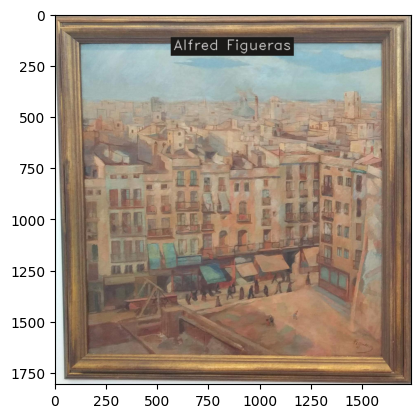

In [860]:
plt.imshow(p[29]["result"][0])

In [861]:
def conver2image(img:np.ndarray):
    return (img*255).astype(np.uint8)

for (idx, result) in (p.items()):
    new_name = result["name"].split(".")[0]+".png"
    Im.fromarray(conver2image(result["mask"])).save(new_name)
    #response_final.append(array["bbox"])
    
#print(response_final)


# Si vols evaluar

In [7]:

p = Path("../data/qsd2_w3/")
img_list = list(p.glob("*.png")) # lista [~/BBDD/bbdd_0000.jpg ...]
masks_to_compare = sorted(img_list)

In [ ]:
precission = []
recall = []
f_score  = []
for idx, im in tqdm(enumerate(BBDD)):
    image = cv2.imread(str(im))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_image = (cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))
    if estimate_noise(gray_image) > 1:
        image = CDenoissing(image)
        
    mask_to_compare = cv2.imread(str(masks_to_compare[idx]))[:,:,0]
    paintings = extract_paintings(image)
    final_mask = np.zeros_like(paintings["mask"])
    
    ## Quan torni mirar això per posar en correspondencia el quadros
    for i, paint_extracted in enumerate(paintings["result"]):
        new_bbox = []
        old_bbox = paintings["bbox"][i]
        new_bbox, new_mask_img = refine_mask(paint_extracted)
        new_y = old_bbox[0] + (new_bbox[0]-old_bbox[0])
        new_x = new_bbox[1] + (new_bbox[1]- old_bbox[1])
        plt.imshow(new_mask)
        
        h = new_bbox[-2]
        w = new_bbox[-1]
        
        final_mask[new_y:new_y+h, new_x:new_x+w] = 1
        #plt.imshow(image[new_y:new_y+h, new_x:new_x+w])
        new_bbox.append([new_y, new_x, h, w])
    
    #plt.imshow(final_mask, cmap="gray")
    paintings["bbox"] = new_bbox
    #plt.imshow(paintings["mask"], cmap="gray")
    paintings["mask"] = final_mask
    plt.imshow(paintings["mask"], cmap="gray")    
    
    mask = paintings["mask"]
    
    precission.append(precision_score(mask.flatten(), (mask_to_compare/255).flatten()))
    recall.append(recall_score(mask.flatten(), (mask_to_compare/255).flatten()))
    f_score.append(f1_score(mask.flatten(), (mask_to_compare/255).flatten()))
    

# A partir d'aquí no fa falta miris res 

In [345]:
plt.imshow(p[1]["result"][0])

IndexError: list index out of range

In [797]:
image_test = cv2.imread(str(BBDD[8]))

In [798]:
img_test = (cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB))

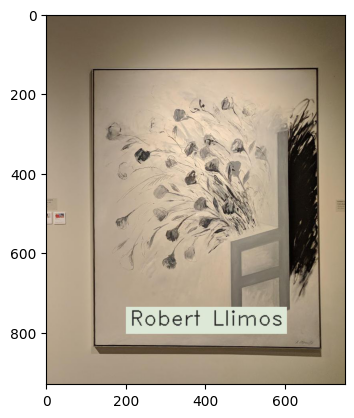

In [799]:
plt.imshow(normalize(img_test))

In [800]:
gray_image = (cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY))
print(estimate_noise(gray_image))
if estimate_noise(gray_image) > 1:
    img_test = CDenoissing(img_test)
gray_image = (cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY))
print(estimate_noise(gray_image))

1.8346376091242305
0.5133173741959745


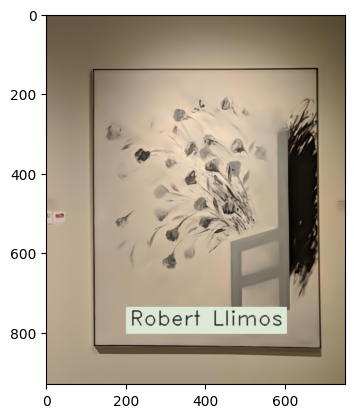

In [801]:
plt.imshow(img_test)

In [802]:
chromacity = conver2colorspace(img_test, colorspace=convert2rg_chromaticity)
#chromacity = chromacity[:,:,[0,1]].mean(axis=2)

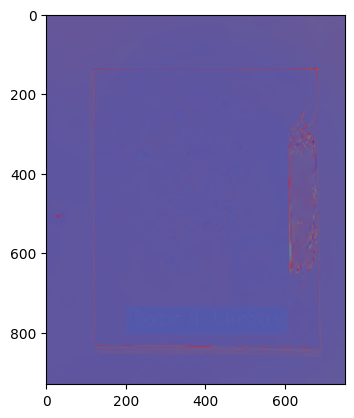

In [803]:
plt.imshow(chromacity)

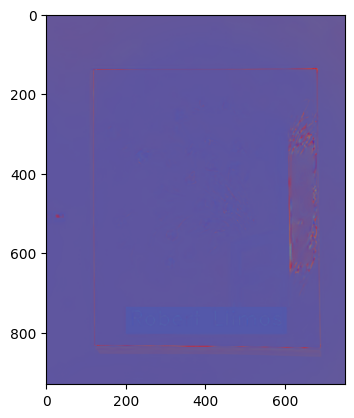

In [804]:
chromacity= ((chromacity *255).astype(np.uint8))

#chromacity = cv2.bilateralFilter(chromacity, 5, 35, 35) 

plt.imshow(chromacity)

In [805]:
### Applying the derivates
x = cv2.Sobel(chromacity, cv2.CV_64F, 1,0, ksize=3, scale=1)
y = cv2.Sobel(chromacity, cv2.CV_64F, 0,1, ksize=3, scale=1)
absx= cv2.convertScaleAbs(x)
absy = cv2.convertScaleAbs(y)
edge = cv2.addWeighted(absx, 1.5, absy, 1.5, 0)

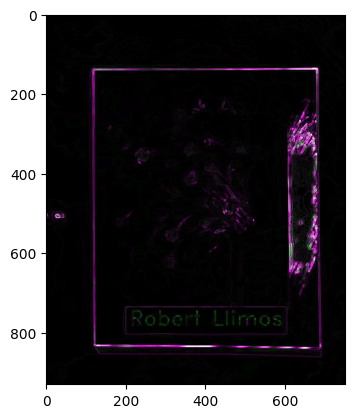

In [806]:
plt.imshow(edge, cmap="gray")

In [807]:
edges = cv2.Canny(edge, 75, 100)

In [808]:
estimate_noise(chromacity[:,:,0])

0.20531542495069036

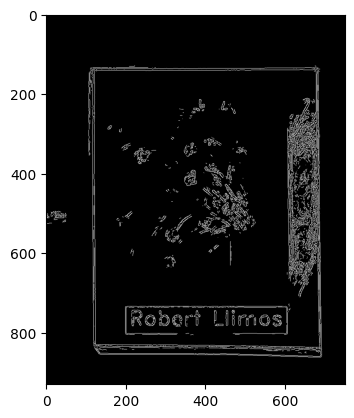

In [809]:
plt.imshow(edges, cmap="gray")

In [810]:
kernel = (int(edges.shape[0]*0.01), int(edges.shape[1]*0.01))#int(edges.shape[1]*0.03)

In [811]:
binary = apply_closing(edges, kernel)


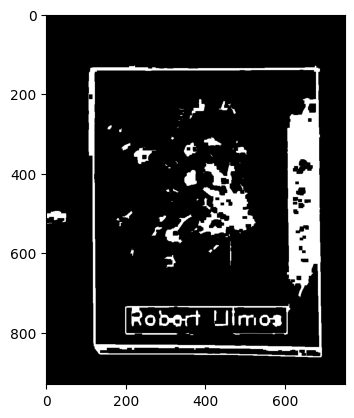

In [812]:
plt.imshow(binary, cmap="gray")

In [813]:
#~binary = apply_open(binary, (3,3) )
binary[0:5,:] = 0
binary[:,0:5] = 0
binary[-5:, :] = 0
binary[:, -5:] = 0
#binary = apply_dilate(binary, (3,3), iterations=5)


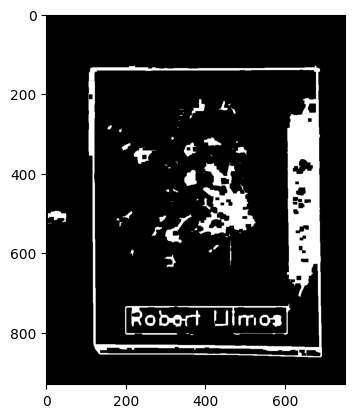

In [814]:
plt.imshow(binary, cmap="gray")

In [815]:
img2 = binary.copy()
h, w = img2.shape
mask = np.zeros((h+2, w+2), np.uint8)



In [816]:
cv2.floodFill(img2, mask, (1,1), 255)
inv = cv2.bitwise_not(img2)

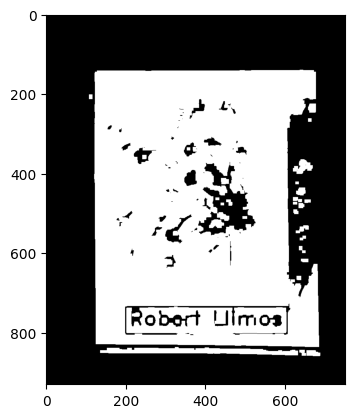

In [817]:
plt.imshow(inv, cmap="gray")

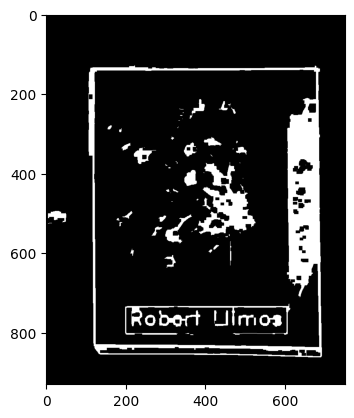

In [818]:
plt.imshow(binary-inv, cmap="gray")

In [819]:
mask = inv + binary

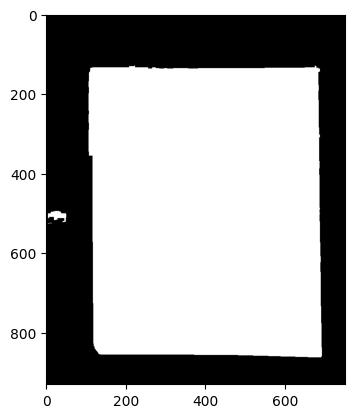

In [820]:
plt.imshow(mask, cmap="gray")

In [821]:
    
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
decission = []
heigh_im, width_im = binary.shape

area_total = heigh_im * width_im

print(len(contours))

for contour in contours:
    convexHull = cv2.convexHull(contour)

    perimeter = cv2.arcLength(convexHull, True)
    x,y,w,h = cv2.boundingRect(convexHull)
    aspect_ratio = w/h
    area = w*h
    proportion_height =  h/heigh_im
    proportion_width = w / width_im

    if (proportion_height > 0.15) and (proportion_width > 0.15):
        decission.append(([y,x,h,w], perimeter, area ,aspect_ratio))

    
print(decission)
decission = sorted(decission, key=lambda x: x[2], reverse=True)
decission = non_maximun_supression(decission)


3
[([129, 107, 734, 587], 2586.25780582428, 430858, 0.7997275204359673)]


In [822]:
print(decission)

[([129, 107, 734, 587], 2586.25780582428, 430858, 0.7997275204359673)]


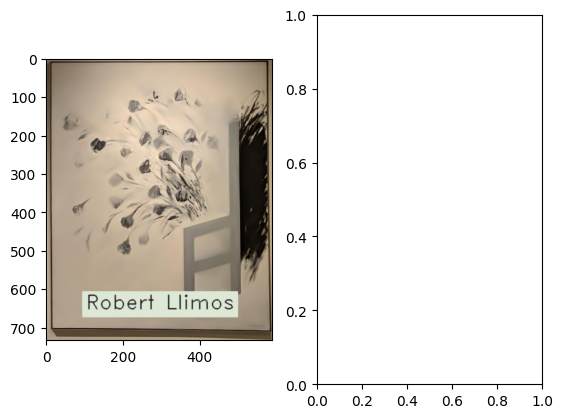

In [823]:
f, axarr = plt.subplots(1,2)

if len(decission) > 2:
    decission = decission[:2]

for idx, dec in enumerate(decission):
    y,x,h,w = dec[0]
    cropped = img_test[y:y+h, x:x+w]
    axarr[idx].imshow(cropped)
    


### Now refine the contours

In [116]:
image_test = cv2.imread(str(BBDD[3]))
img_test = (cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB))
gray_image = (cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY))
if estimate_noise(gray_image) > 1:
    img_test = CDenoissing(img_test)

In [117]:
paintings = extract_paintings(img_test)


In [118]:
print(len(paintings["result"]))

1


In [119]:
final_mask = np.zeros_like(paintings["mask"])

for i, paint_extracted in enumerate(paintings["result"]):

    new_bbox = []
    old_bbox = paintings["bbox"][i]
    print(old_bbox, "old_bbox")
    new_bbox, new_mask_img = refine_mask(paint_extracted)
    print(new_bbox, "new_bbox")

    # Realocate the new refined masks
    new_y =  (old_bbox[0 ] + new_bbox[0])
    new_x =  (old_bbox[1] + new_bbox[1])

    h = new_bbox[-2]
    w = new_bbox[-1]

    final_mask[new_y:new_y+h, new_x:new_x+w] = 1
    new_bbox.append([new_y, new_x, h, w])

[49, 122, 1500, 1960] old_bbox
[6, 3, 1490, 1957] new_bbox


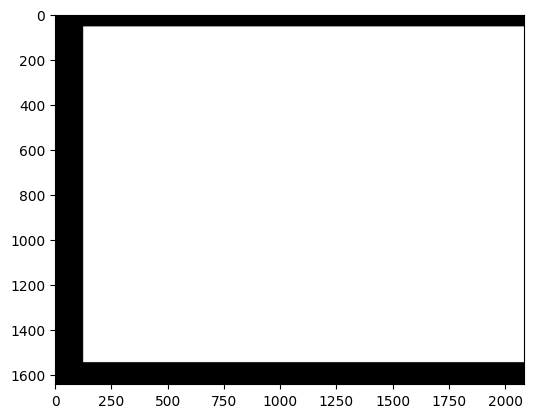

In [120]:
plt.imshow(final_mask, cmap="gray")

In [121]:
bb = refine_mask(final_mask)

ValueError: not enough values to unpack (expected 3, got 1)

In [122]:
#y,x,w,h = bb[0]

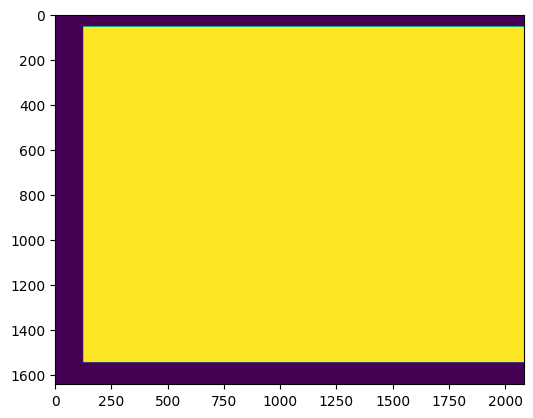

In [123]:
plt.imshow(final_mask)

In [124]:
img_to_test = copy.copy(final_mask)


In [60]:
image = ((normalize(rg[:,:,0]))*255).astype(np.uint8)

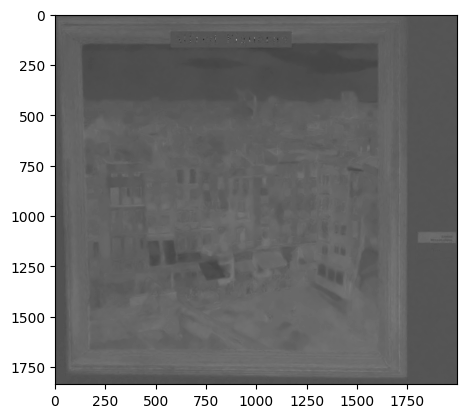

In [61]:
plt.imshow(image, cmap="gray")

In [62]:
#bbox = refine_mask(img_to_test)

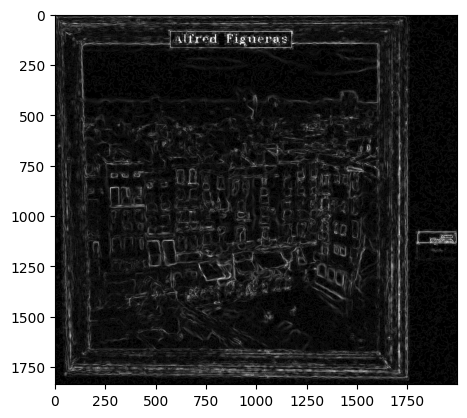

In [63]:
x = cv2.Sobel(image, cv2.CV_64F, 1,0, ksize=3, scale=1)
y = cv2.Sobel(image, cv2.CV_64F, 0,1, ksize=3, scale=1)
absx= cv2.convertScaleAbs(x)
absy = cv2.convertScaleAbs(y)
edge = cv2.addWeighted(absx, 5, absy, 5, 0)
plt.imshow(edge, cmap="gray")

In [64]:
thr = filters.threshold_otsu(edge)
edge = (edge > thr).astype(np.uint8)

## Apply hough transform
mask = np.zeros_like(edge)

In [65]:
mask = np.zeros_like(edge)
max_line_gap = int(edge.shape[1] * 0.05)
h_, w_ = edge.shape
votes_min_l = int(min(h_*0.35, w_*0.35))

linesP = cv2.HoughLinesP(edge, 1, np.pi / 180, votes_min_l, minLineLength=votes_min_l, maxLineGap=max_line_gap)   

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(mask, (l[0], l[1]), (l[2], l[3]), 255, 3, cv2.LINE_AA)

#mask = apply_erode(mask, (7,7))

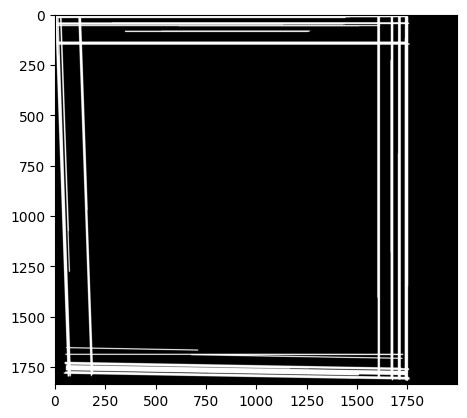

In [66]:
plt.imshow(mask, cmap="gray")

In [67]:
(img2.shape[0]//2,img2.shape[1]//2)

(1168, 1996)

In [68]:
img2 = mask.copy()
h, w = img2.shape
seed = (w//2,h//2)

mask_ = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(img2, mask_, seed, 255)
inv = cv2.bitwise_not(img2)

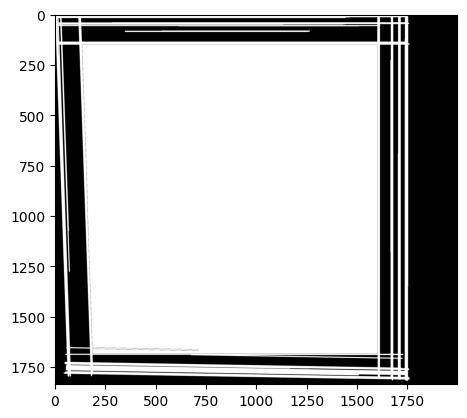

In [69]:
plt.imshow(img2, cmap="gray")

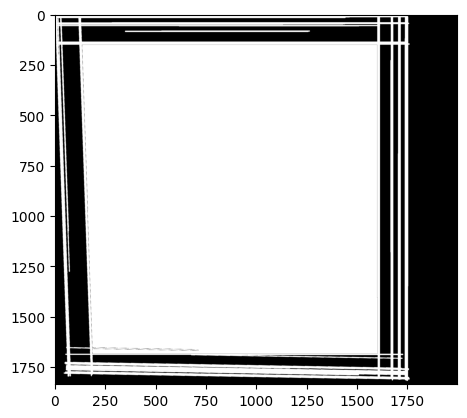

In [70]:
mask_ = mask + img2
#mask_[0:50,:] = 0
#mask_[-50:,:] = 0
plt.imshow(mask_, cmap="gray")

In [71]:
## Get the center of the image
contours, hierarchy = cv2.findContours(mask_, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
decission = []
heigh_im, width_im = edge.shape

area_total = heigh_im * width_im


for contour in contours:
    convexHull = cv2.convexHull(contour)

    perimeter = cv2.arcLength(convexHull, True)
    x,y,w,h = cv2.boundingRect(convexHull)
    aspect_ratio = w/h
    area = w*h
    proportion_height =  h/heigh_im
    proportion_width = w / width_im

    if (proportion_height  > 0.15) and (proportion_width > 0.15) and width_im :
        decission.append(([y,x,h,w], perimeter, area ,aspect_ratio))


decission = sorted(decission, key=lambda x: x[2], reverse=True)
decission = non_maximun_supression(decission)
    

In [73]:
print(decission)

[([0, 0, 1821, 1760], 7065.1816120147705, 3204960, 0.9665019220208677)]


(1821, 1760, 3)
(1836, 1998, 3)


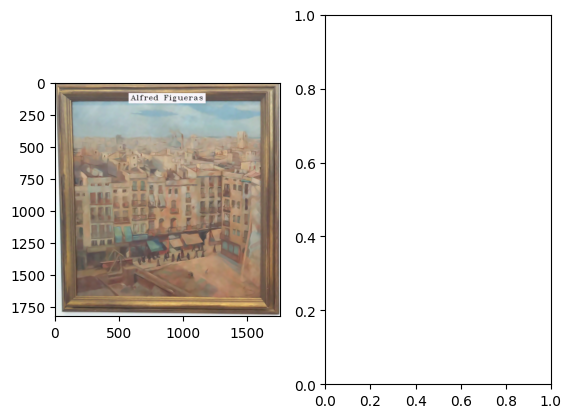

In [74]:
f, axarr = plt.subplots(1,2)

if len(decission) > 2:
    decission = decission[:2]

for idx, dec in enumerate(decission):
    y,x,h,w = dec[0]
    cropped = img_to_test[y:y+h, x:x+w]
    axarr[idx].imshow(cropped)
    
print(cropped.shape)
print(img_to_test.shape)

In [2439]:
p = Path("../data/qsd2_w3/")
img_list = list(p.glob("*.png")) # lista [~/BBDD/bbdd_0000.jpg ...]
masks_to_compare = sorted(img_list)

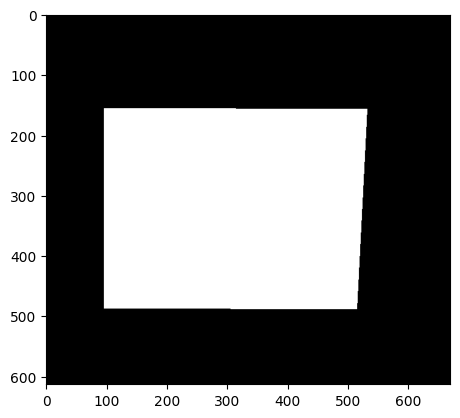

In [2440]:
h = cv2.imread(str(masks_to_compare[0]))
plt.imshow(h[:,:,0],cmap="gray")

In [2718]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

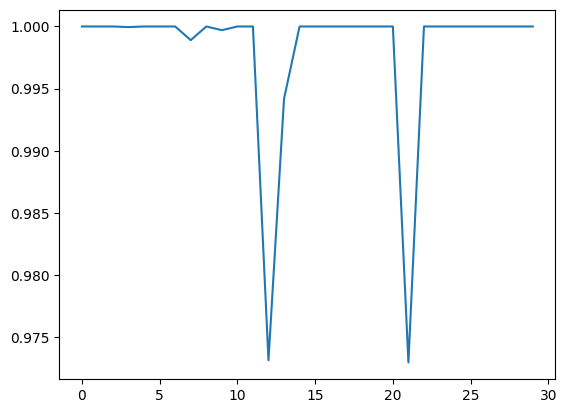

In [2722]:
plt.plot(precission)

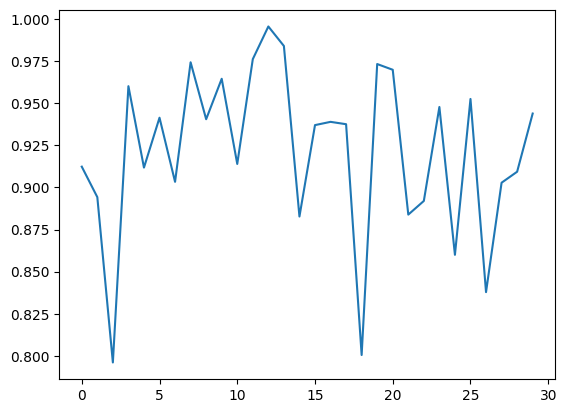

In [2723]:
plt.plot(recall)

In [2724]:
np.argmin(precission)

21

In [2725]:
np.argmin(recall)

2

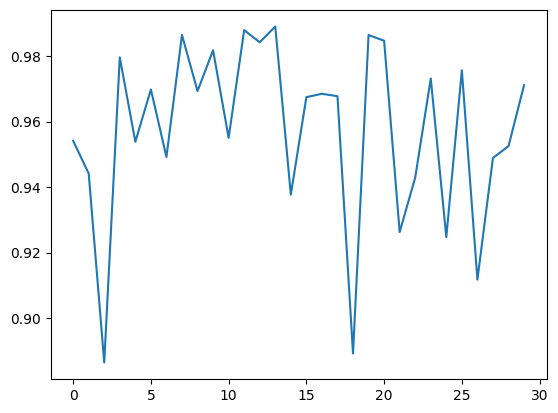

In [2726]:
plt.plot(f_score)

In [2727]:
print(np.mean(precission))
print(np.mean(recall))
print(np.mean(f_score))

0.9979614318858478
0.9212833761928084
0.9573421677777105


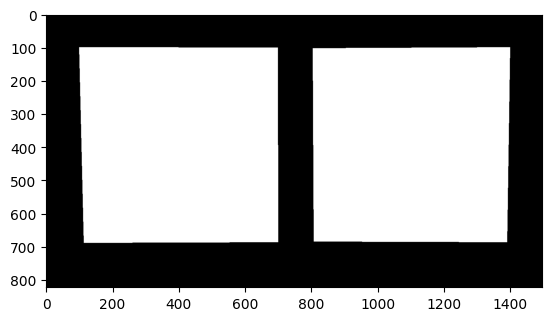

In [3636]:
h = cv2.imread(str(masks_to_compare[0]))
plt.imshow(h[:,:,0],cmap="gray")